In [74]:
import geopandas as gpd
import pandas as pd
import rasterio as rio
from rasterio.plot import show
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
from shapely import box

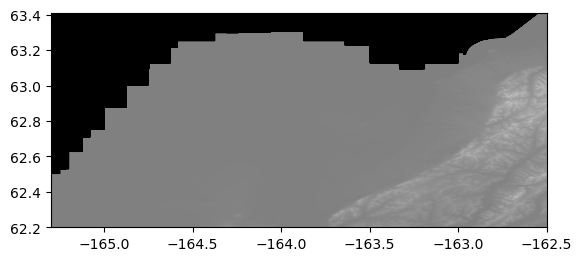

In [2]:
#import YkDelta Elevation
Elev = rio.open("Data/elevation.tif")
show(Elev,cmap = 'gray',vmin=-1000,vmax=1000)
#transfer to panda array
Elev_arr = Elev.read(1)

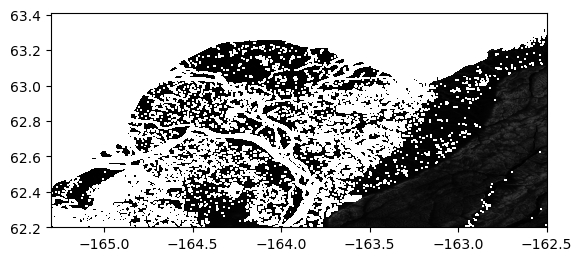

In [3]:
#import YkDelta Slope
Slope = rio.open("Data/slope.tif")
show(Slope,cmap = 'gray',vmin=0,vmax=90)
Slope_arr = Slope.read(1)

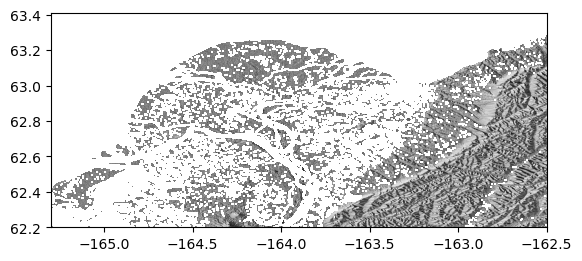

In [4]:
#import YkDelta Aspect
Aspect = rio.open("Data/aspect.tif")
show(Aspect,cmap = 'gray',vmin=0,vmax=360)
Aspect_arr = Aspect.read(1)

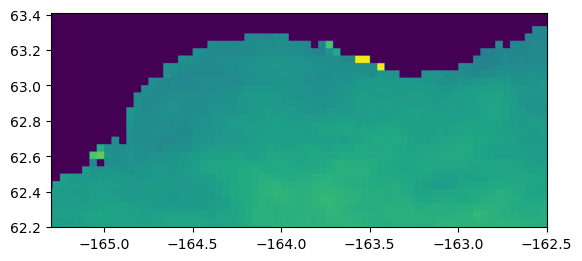

<Axes: >

In [5]:
#import YkDelta Average Max Monthly Temperature years 2000-2021 
max_avg_temp = []
for i in range(2000,2022,1):
    file_name = "Data/avg_maxtemp/avgmaxTemp_" + str(i) + ".tif"
    temp = rio.open(file_name) 
    temp_arr = temp.read(1)
    max_avg_temp.append(temp_arr)
show(temp)

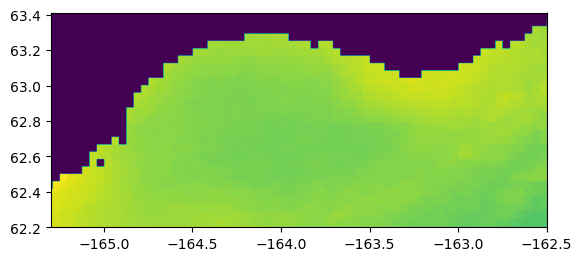

<Axes: >

In [6]:
#import Precipitation years 2000-2021 
precip = []
for i in range(2000,2022,1):
    file_name = "Data/precip/precip_" + str(i) + ".tif"
    pr = rio.open(file_name) 
    pr_arr = pr.read(1)
    precip.append(pr_arr)
show(pr)

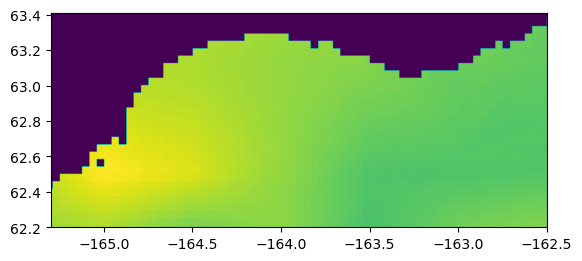

<Axes: >

In [23]:
#import Average Soil Moisture years 2000-2021 
soil = []
for i in range(2000,2022,1):
    file_name = "Data/soil/soil_" + str(i) + ".tif"
    sm = rio.open(file_name) 
    sm_arr = sm.read(1)
    soil.append(sm_arr)
show(sm)

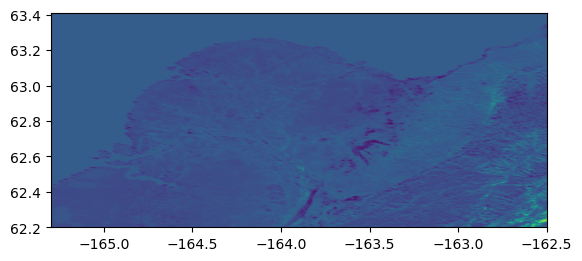

<Axes: >

In [22]:
# import NDVI years 2000-2021 
NDVI = []
for i in range(2000,2022,1):
    file_name = "Data/NDVI/NDVI_" + str(i) + ".tif"
    vi = rio.open(file_name) 
    vi_arr = vi.read(1)
    NDVI.append(vi_arr)
show(vi)

In [86]:
#import wildfire history
points_2020 = gpd.read_file('Data/wildfire_history/AgencyHistoricFirePerimeters_2020/AgecnyHistoricFirePerimeters_2020.shp')
points_2010 = gpd.read_file('Data/wildfire_history/AgencyHistoricFirePerimeters_2010_2019/AgencyHistoricFirePerimeters_2010_2019.shp')
points_2000 = gpd.read_file('Data/wildfire_history/AgencyHistoricFirePerimeters_2000_2009/AgencyHistoricFirePerimeters_2000_2009.shp')
#points_1990 = gpd.read_file('Data/wildfire_history/AgencyHistoricFirePerimeters_1990_1999/AgencyHistoricFirePerimeters_1990_1999.shp')
#points_1980 = gpd.read_file('Data/wildfire_history/AgencyHistoricFirePerimeters_1980_1989/AgencyHistoricFirePerimeters_1980_1989.shp')
#points_earlier = gpd.read_file('Data/wildfire_history/AgencyHistoricFirePerimeters_1979_Earlier/AgencyHistoricFirePerimeters_1979_Earlier.shp')

In [97]:
#combine all wildfire history
wildfire_points = gpd.GeoDataFrame(pd.concat([points_2020,points_2010,points_2000],ignore_index = True))
#wildfire_points = gpd.GeoDataFrame(pd.concat([points_2020,points_2010,points_2000,points_1990,points_1980,points_earlier]))
wildfire_points

,IRWINID,INCIDENT,FIRE_YEAR_,FIRE_YEAR,AGENCY,SOURCE,DATE_CUR,MAP_METHOD,GIS_ACRES,UNQE_FIRE_,LOCAL_NUM,UNIT_ID,POO_RESP_I,FEATURE_CA,COMMENTS,GEO_ID,OOID,OBJECTID,geometry
0,None,NELSON,2020,2020,CDF,CalFire FRAP,20200623,GPS Ground,109.602501,None,00013212,CANEU,None,Wildfire,None,1,21440,1,"POLYGON ((-121.34840 38.88999, -121.34835 38.8..."
1,None,AMORUSO,2020,2020,CDF,CalFire FRAP,20200604,GPS Ground,685.585022,None,00011799,CANEU,None,Wildfire,None,2,21441,2,"POLYGON ((-121.35275 38.82038, -121.35267 38.8..."
2,None,ATHENS,2020,2020,CDF,CalFire FRAP,20200301,GPS Ground,27.300480,None,00018493,CANEU,None,Wildfire,None,3,21442,3,"POLYGON ((-121.33333 38.84558, -121.33311 38.8..."
3,None,FLEMING,2020,2020,CDF,CalFire FRAP,20200401,GPS Ground,12.931550,None,00007619,CANEU,None,Wildfire,None,4,21443,4,"POLYGON ((-121.27317 38.96308, -121.27304 38.9..."
4,None,MELANESE,2020,2020,CDF,CalFire FRAP,20200419,GPS Ground,10.315960,None,00008471,CANEU,None,Wildfire,None,5,21444,5,"POLYGON ((-121.30065 39.48714, -121.30041 39.4..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47968,None,Montgomery,2009,2009,BLM,BLM,201802121157,Mixed Methods,289.935970,2009-CACDD-005602,5602,USCACDD,USCACDD,Wildfire,None,{552F6DF6-7918-4667-BAD5-D86373C4E81C},188418,107389,"POLYGON ((-115.37227 33.16523, -115.37225 33.1..."
47969,None,Midway,2009,2009,BLM,BLM,201802121157,Mixed Methods,111.609330,2009-CACDD-005989,5989,USCAPRI,USCACDD,Wildfire,None,{B98CD870-5605-4F53-A1B4-7A87B6D3E2ED},188441,107412,"MULTIPOLYGON (((-115.11094 32.70706, -115.1109..."
47970,None,Lamb,2009,2009,BLM,BLM,201802121157,Mixed Methods,288.135200,2009-CACDD-060763,60763,USCAPRI,USCARRU,Wildfire,None,{6C9222AA-930B-433F-A732-88E0FD05C5E7},188488,107456,"POLYGON ((-116.99752 33.86912, -116.99731 33.8..."
47971,None,Tram,2009,2009,BLM,BLM,201802121157,Mixed Methods,49.937878,2009-CACDD-005399,5399,USCAPRI,USCABDF,Wildfire,None,{D98C3BC8-9468-413E-ABEC-4AD540CCCC50},188503,107470,"POLYGON ((-116.55948 33.85561, -116.55950 33.8..."


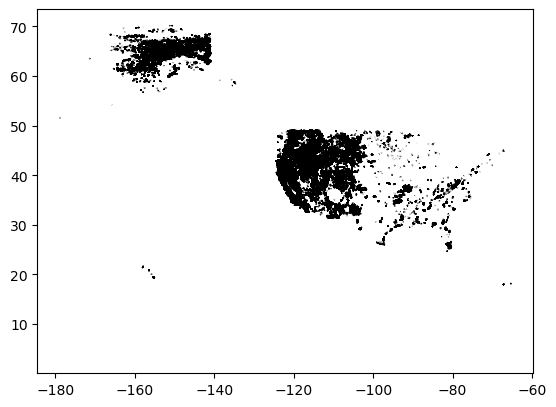

In [98]:
#plt.imshow(test_arr, cmap = 'gray')
f ,ax = plt.subplots()
tiff_extent = [Elev.bounds[0], Elev.bounds[2], Elev.bounds[1], Elev.bounds[3]]
#show(Elev.read(1),extent = tiff_extent, ax = ax )
#ax = plt.gca()
wildfire_points.plot(facecolor = 'w', edgecolor = 'k', ax = ax)#ax = plt.gca())
plt.show()

In [40]:
print(Elev.bounds)

BoundingBox(left=-165.30061239834455, bottom=62.199799430077725, right=-162.4998450055167, top=63.407135171934364)


<Axes: >

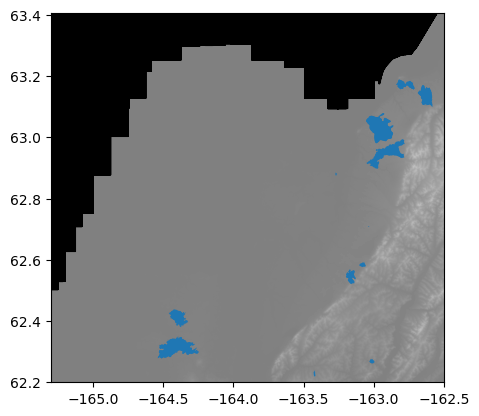

In [102]:
min_x = Elev.bounds[0]
max_x = Elev.bounds[2]
min_y = Elev.bounds[1]
max_y = Elev.bounds[3]




bbox = box(min_x, min_y, max_x, max_y)

wildfire_points_roi = wildfire_points[wildfire_points.geometry.within(bbox)]
#test
f, ax = plt.subplots()
show(Elev, ax = ax, cmap = 'gray', vmin=-1000,vmax=1000)
wildfire_points_roi.plot(ax = ax)
#test.plot()
#plt.show()

In [103]:
print(len(wildfire_points_roi))

21


In [104]:
wildfire_points_roi

,IRWINID,INCIDENT,FIRE_YEAR_,FIRE_YEAR,AGENCY,SOURCE,DATE_CUR,MAP_METHOD,GIS_ACRES,UNQE_FIRE_,LOCAL_NUM,UNIT_ID,POO_RESP_I,FEATURE_CA,COMMENTS,GEO_ID,OOID,OBJECTID,geometry
1206,{1A22F30B-799A-46A0-9249-DB2734E2F4AE},Pastoliak River,2020,2020,AICC,AFS,202006181400,Image Interpretation,59.288490,2020-AKGAD-000280,000280,None,AKGAD,Wildland Final Fire Perimeter,Perimeter digitized using Sentinel 2 image col...,{A7D7E4E5-19DB-4B48-926F-DB6446D2A0A5},48,76934,"POLYGON ((-162.98149 62.95970, -162.98108 62.9..."
1441,None,20280 Pastoliak Lake,2020,2020,FWS,FWS,None,None,59.600000,2020USAKYDRM6Z5,M6Z5,AKYDR,None,Wildfire,Initial Report On Conditions:\r\nVIIRS seen 6/...,150,150,82836,"POLYGON ((-162.98149 62.95970, -162.98108 62.9..."
16222,E62589A2-BEEB-4C62-B7E3-B5AB44788049,Andreafsky,2017,2017,AICC,AFS,201707221425,Image Interpretation,512.227900,2017-AKGAD-000206,000206,None,AKGAD,Wildland Final Fire Perimeter,Perimeter updated using Sentinel 2 imagery.,{AD309E10-F1BA-4474-ABB2-4C786DC7C707},594,77480,"POLYGON ((-163.02204 62.26321, -163.02280 62.2..."
16244,2B4F6923-8854-45F4-86B3-501F635FE76F,Allen,2017,2017,AICC,AFS,201707061411,Image Interpretation,2583.490500,2017-AKGAD-000197,000197,None,AKGAD,Wildland Final Fire Perimeter,Perimeter updated using Landsat 7 image.,{4978CB1C-BB87-4786-A06A-A0C8C2AD746F},616,77502,"POLYGON ((-163.18388 62.55729, -163.18302 62.5..."
16245,B8494C1F-E7D7-4AD3-BF8F-EF9E364DEA88,Romanoff,2017,2017,AICC,AFS,201707061411,Image Interpretation,3114.854700,2017-AKGAD-000234,000234,None,AKGAD,Wildland Final Fire Perimeter,Perimeter updated using Landsat 7 imagery.,{183C4137-5BEC-480F-A2E6-3ABF1367C1AD},617,77503,"POLYGON ((-162.82381 63.18621, -162.82333 63.1..."
16246,14FA22FA-6A8C-4B81-869D-085171A70D8E,Kogok 3,2017,2017,AICC,AFS,201707061411,Image Interpretation,6087.852000,2017-AKGAD-000192,000192,None,AKGAD,Wildland Final Fire Perimeter,Perimeter updated using Landsat 7 imagery.,{D8492CEE-020E-45FA-82ED-D890470517B5},618,77504,"POLYGON ((-162.66321 63.12958, -162.66365 63.1..."
16270,5D51BD09-96C4-4973-868C-9DB8D08EA242,Pastolik,2017,2017,AICC,AFS,201706151100,Image Interpretation,11.494000,2017-AKGAD-000213,000213,None,AKGAD,Wildland Final Fire Perimeter,Perimeter digitized using Sentinel 2 image col...,{52609897-6DB5-4792-BE37-2C3867941CEE},642,77528,"POLYGON ((-163.03354 62.70899, -163.03330 62.7..."
16682,6E651734-9DE4-4B1F-B14E-9DCF7DBEE353,Igokluk Slough,2015,2015,AICC,AFS,201507101500,Image Analysis,5645.336000,2015-AKSWS-000459,000459,None,AKSWS,Wildland Final Fire Perimeter,None recorded,{94768385-A84C-4B39-A77A-CE9D45FB982B},1054,77940,"POLYGON ((-164.35417 62.41824, -164.35483 62.4..."
16683,2367FF31-EB4C-42DF-9BBB-867AC019B6C7,Anakshek Pass,2015,2015,AICC,AFS,201507101500,Image Analysis,15001.927000,2015-AKSWS-000447,000447,None,AKSWS,Wildland Final Fire Perimeter,None recorded,{20610F2D-9D11-4546-BBE3-47BE0FD9A93F},1055,77941,"POLYGON ((-164.39258 62.34280, -164.39299 62.3..."
16706,754CA1B0-59BF-412F-BDB5-B3875D1F1B1D,Apoon,2015,2015,AICC,AFS,201507051400,Digitized,15031.901000,2015-AKGAD-000451,000451,None,AKGAD,Wildland Final Fire Perimeter,Perimeter estimated using VIIRS/MODIS,{4813C9F9-C78B-4CD7-8AC6-68A3C32A10EA},1078,77964,"POLYGON ((-162.96129 62.98727, -162.96285 62.9..."


In [106]:
wildfire_points.loc[1]

IRWINID                                                    None
INCIDENT                                                AMORUSO
FIRE_YEAR_                                                 2020
FIRE_YEAR                                                  2020
AGENCY                                                      CDF
SOURCE                                             CalFire FRAP
DATE_CUR                                               20200604
MAP_METHOD                                           GPS Ground
GIS_ACRES                                            685.585022
UNQE_FIRE_                                                 None
LOCAL_NUM                                              00011799
UNIT_ID                                                   CANEU
POO_RESP_I                                                 None
FEATURE_CA                                             Wildfire
COMMENTS                                                   None
GEO_ID                                  